In [36]:
import trenchripper as tr

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import warnings
import random

from matplotlib import pyplot as plt

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

random.seed(42)
np.random.seed(42)

dask_wd = "/home/de64/scratch/de64/dask"

warnings.filterwarnings(action='once',category=UserWarning)

plt.style.use('./deaton.mplstyle')

### Load Functions

In [34]:
def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

def get_std(plate_data,plate_map,plate_map_std_dict):
    standard_vals = []
    standard_signal = []
    for key,val in plate_map_std_dict.items():
        selected_data = np.array(plate_data[plate_map==key]).flatten()
        selected_data = selected_data[~np.isnan(selected_data)]
        working_standard_vals = [val for i in range(len(selected_data))]
        standard_vals += working_standard_vals
        standard_signal += list(selected_data)
    standard_vals = np.array(standard_vals)
    standard_signal = np.array(standard_signal)
    return standard_vals,standard_signal

def linear_regression(plate_data,plate_map,plate_map_std_dict):
    ##extract standard values
    std_vals,std_signal = get_std(plate_data,plate_map,plate_map_std_dict)
    
    ##linear regression
    reg = skl.linear_model.LinearRegression().fit(std_vals.reshape(-1,1),std_signal)
    predict = reg.predict(std_vals.reshape(-1,1))
    resid = (std_signal - predict)
    reg_uncertainty = np.sqrt(np.sum(resid**2)/(len(resid)-2))
    slope_uncertainty = reg_uncertainty/np.sqrt(np.sum((std_vals-np.mean(std_vals))**2))

    ## calculating LOQ by standard error of regression slope
    deriv = reg.coef_[0]    
    intercept = reg.intercept_
    loq = 10*(slope_uncertainty/deriv)
    print("LOQ: " + str(loq))
    
    predicted_concentrations = plate_data.apply(lambda x: (x-intercept)/deriv)
    samples_mask = ~plate_map.isin(list(plate_map_std_dict.keys()) + [np.NaN])
    all_samples_list = plate_map.values[samples_mask.values]
    all_sample_vals_list = predicted_concentrations.values[samples_mask.values]
    return all_samples_list,all_sample_vals_list

### Load Data

In [3]:
short_expt_raw_pkl = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Clustering/2023-01-23_sgRNA_Timeseries_df.pkl")
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

all_slopes_filtered = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Growth_Length_Slopes.csv",index_col="Gene")
filtered_ss_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(all_slopes_filtered.index.tolist())]

In [4]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Instantaneous Growth Rate: Volume']
prolif_params = []
param_names = [r"Length ($ \mu m $)",r"Volume ($ \mu m^{3} $)"]
param_ranges = [(0.,10.),(0.,2.2)]
param_ticks = [[0,2,4,6,8,10],[0.,1.,2.]]

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

# ##removing controls
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

In [5]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://current.geneontology.org/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

  EXISTS: go-basic.obo
requests.get(http://current.geneontology.org/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:01.256469  58,540 annotations READ: ./ecocyc.gaf 


## Figure 3A

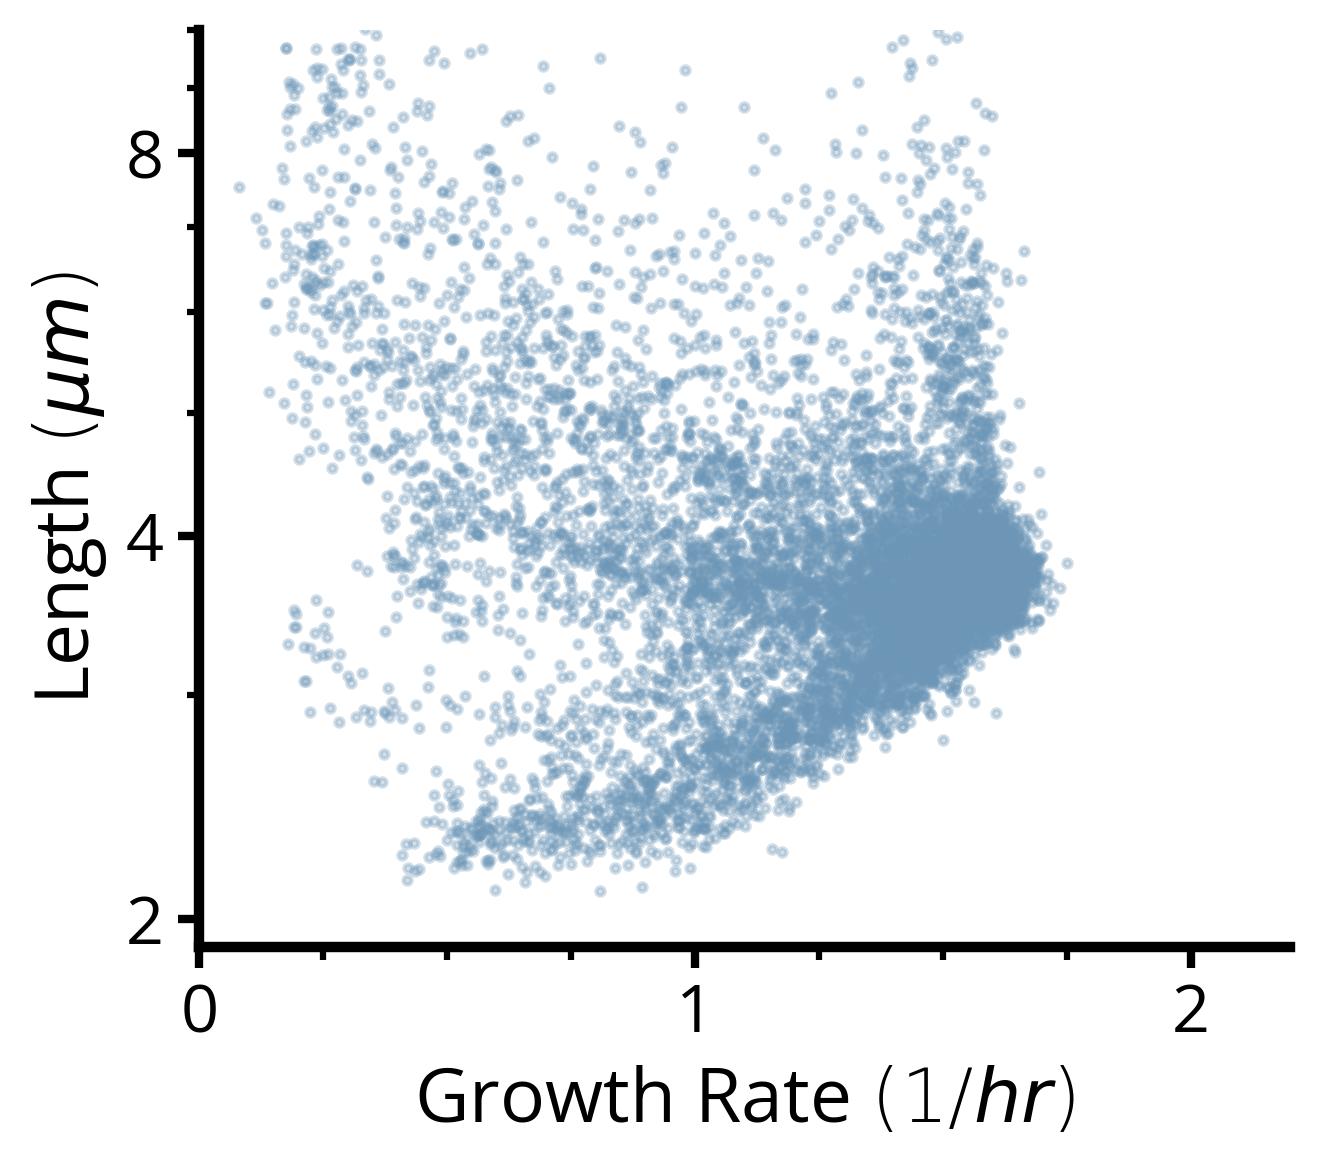

In [6]:
sns.set_style()
fig,ax = plt.subplots(1,1,figsize=(4.5,4))
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,10)
plt.yscale("log",base=2)

ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)

ax.scatter(ss_estimators_df["Instantaneous Growth Rate: Volume"],ss_estimators_df["Length"],s=4,color="#6B95B6",alpha=0.3)
plt.ylabel(r"Length $ (\mu m) $",fontsize=18)
plt.xlabel(r"Growth Rate $ (1/hr) $",fontsize=18)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/8hr_Induced_Length_Growth_Long.png",dpi=500,transparent=True,bbox_inches="tight")

## Figure 3B

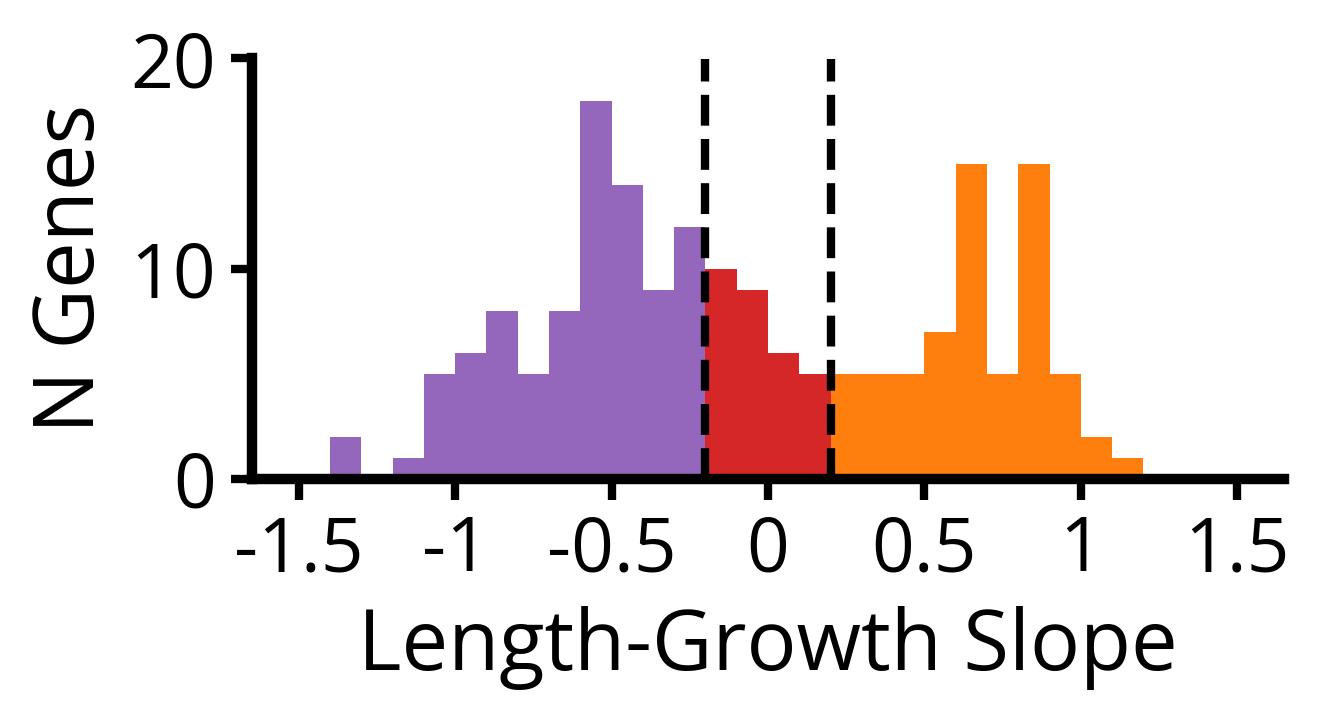

In [7]:
## make this pretty

pos_slope_thr = 0.2
neg_slope_thr = -0.2

all_genes = all_slopes_filtered.index.tolist()
pos_slope_genes = all_slopes_filtered[all_slopes_filtered["Slope"]>=pos_slope_thr].index.tolist()
neg_slope_genes = all_slopes_filtered[all_slopes_filtered["Slope"]<=neg_slope_thr].index.tolist()
no_slope_genes = all_slopes_filtered[(all_slopes_filtered["Slope"]>neg_slope_thr)&\
                (all_slopes_filtered["Slope"]<pos_slope_thr)].index.tolist()

fig,ax = plt.subplots(1,1,figsize=(4.5,2.5))

plt.ylim(0,20)

ax.hist(all_slopes_filtered[all_slopes_filtered["Slope"]<=neg_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:purple")
ax.hist(all_slopes_filtered[(all_slopes_filtered["Slope"]>neg_slope_thr)&\
                             (all_slopes_filtered["Slope"]<pos_slope_thr)]["Slope"],range=(-1.5,1.5),bins=30,color="tab:red")
ax.hist(all_slopes_filtered[all_slopes_filtered["Slope"]>=pos_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:orange")
ax.vlines([neg_slope_thr,pos_slope_thr],ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--",linewidth=2,color="black")

ax.set_xlabel(r"Length-Growth Slope",fontsize=20)
ax.set_ylabel("N Genes",fontsize=20)
ax.set_xticks(ticks=[-1.5,-1,-0.5,0,0.5,1,1.5],labels=["-1.5","-1","-0.5","0","0.5","1","1.5"],minor=False)
ax.set_yticks(ticks=[0,10,20],minor=False)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Slope_Hist.png",transparent=True,dpi=500,bbox_inches="tight")

### Plot Example Slopes

-0.1083480965324817


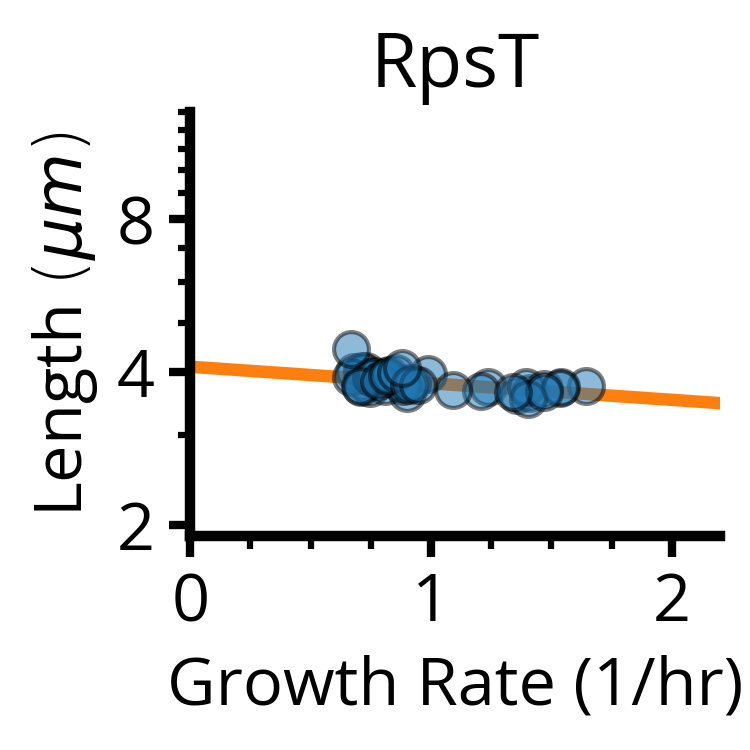

In [8]:
gene_name = "rpsT"

selected_slope,selected_intercept = all_slopes_filtered.loc[gene_name]["Slope"],all_slopes_filtered.loc[gene_name]["Intercept"]
selected_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"] == gene_name]
print(selected_slope)

fig,ax = plt.subplots(1,1,figsize=(2.6,2.6))

xrange = np.linspace(0,2.2)
ax.plot(xrange, 2**(xrange*selected_slope + selected_intercept),linewidth=3,zorder=-1,color="tab:orange")
ax.scatter(selected_points.loc["Instantaneous Growth Rate: Volume"]["Value"]/np.log(2),selected_points.loc["Length"]["Value"],edgecolors='black',alpha=0.5,s=70,zorder=0)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=16)
ax.set_ylabel("Length $ (\mu m) $",fontsize=16)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=18)
sns.despine(right=True,top=True)
# plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Slope_Hist_ValS.png",transparent=True,dpi=500,bbox_inches="tight")

0.811414727631184


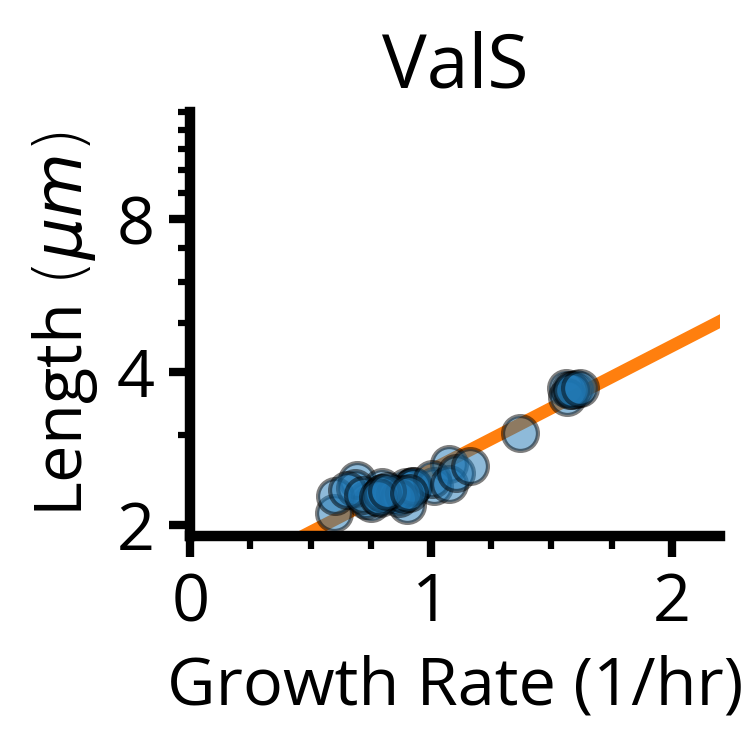

In [9]:
gene_name = "valS"

selected_slope,selected_intercept = all_slopes_filtered.loc[gene_name]["Slope"],all_slopes_filtered.loc[gene_name]["Intercept"]
selected_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"] == gene_name]
print(selected_slope)

fig,ax = plt.subplots(1,1,figsize=(2.6,2.6))

xrange = np.linspace(0,2.2)
ax.plot(xrange, 2**(xrange*selected_slope + selected_intercept),linewidth=3,zorder=-1,color="tab:orange")
ax.scatter(selected_points.loc["Instantaneous Growth Rate: Volume"]["Value"]/np.log(2),selected_points.loc["Length"]["Value"],edgecolors='black',alpha=0.5,s=70,zorder=0)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=16)
ax.set_ylabel("Length $ (\mu m) $",fontsize=16)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=18)
sns.despine(right=True,top=True)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Slope_Hist_ValS.png",transparent=True,dpi=500,bbox_inches="tight")

0.0538979580347275


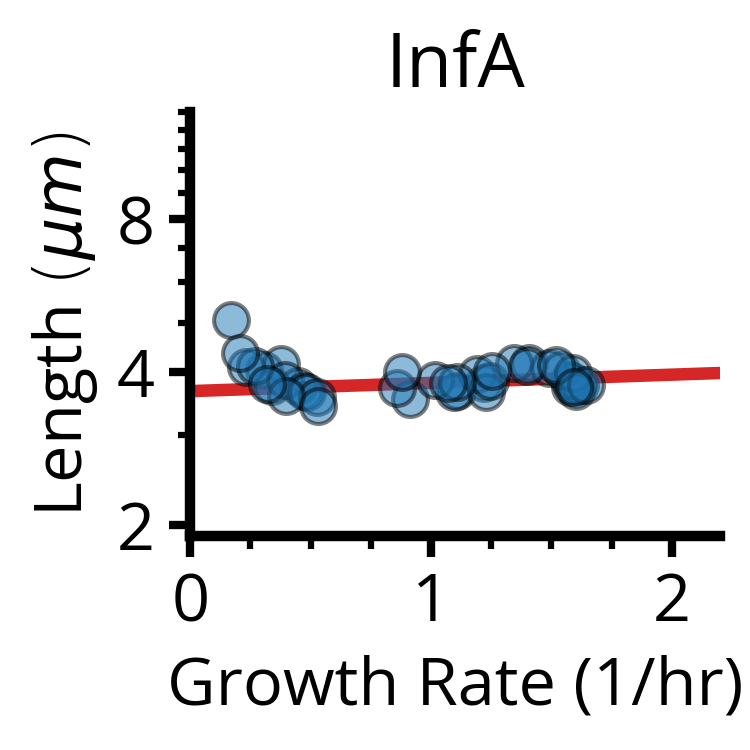

In [10]:
gene_name = "infA"

selected_slope,selected_intercept = all_slopes_filtered.loc[gene_name]["Slope"],all_slopes_filtered.loc[gene_name]["Intercept"]
selected_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"] == gene_name]
print(selected_slope)

fig,ax = plt.subplots(1,1,figsize=(2.6,2.6))

xrange = np.linspace(0,2.2)
ax.plot(xrange, 2**(xrange*selected_slope + selected_intercept),linewidth=3,zorder=-1,color="tab:red")
ax.scatter(selected_points.loc["Instantaneous Growth Rate: Volume"]["Value"]/np.log(2),selected_points.loc["Length"]["Value"],edgecolors='black',alpha=0.5,s=70,zorder=0)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=16)
ax.set_ylabel("Length $ (\mu m) $",fontsize=16)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=18)
sns.despine(right=True,top=True)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Slope_Hist_InfA.png",transparent=True,dpi=500,bbox_inches="tight")

-0.9868008682629756


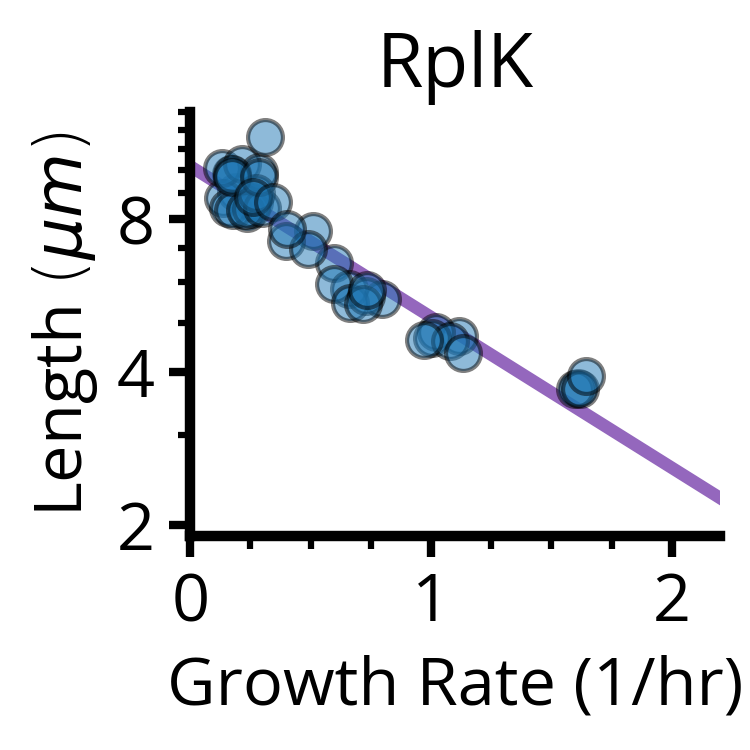

In [11]:
gene_name = "rplK"

selected_slope,selected_intercept = all_slopes_filtered.loc[gene_name]["Slope"],all_slopes_filtered.loc[gene_name]["Intercept"]
selected_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"] == gene_name]
print(selected_slope)

fig,ax = plt.subplots(1,1,figsize=(2.6,2.6))

xrange = np.linspace(0,2.2)
ax.plot(xrange, 2**(xrange*selected_slope + selected_intercept),linewidth=3,zorder=-1,color="tab:purple")
ax.scatter(selected_points.loc["Instantaneous Growth Rate: Volume"]["Value"]/np.log(2),selected_points.loc["Length"]["Value"],edgecolors='black',alpha=0.5,s=70,zorder=0)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=16)
ax.set_ylabel("Length $ (\mu m) $",fontsize=16)
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,13)
ax.set_yscale("log",base=2)
ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
ax.set_title(gene_name[0].capitalize() + gene_name[1:],fontsize=18)
sns.despine(right=True,top=True)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Slope_Hist_RplK.png",transparent=True,dpi=500,bbox_inches="tight")

## Figure 3C

In [12]:
trna_synthetases = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006418")
lipid_metabolic_process = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006629")
all_ribosome = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0005840")
all_r_proteins = [item for item in all_ribosome if ("rpl" in item)|("rpm" in item)|("rps" in item)]

Searching for tRNA aminoacylation for protein translation
Searching for lipid metabolic process
Searching for ribosome


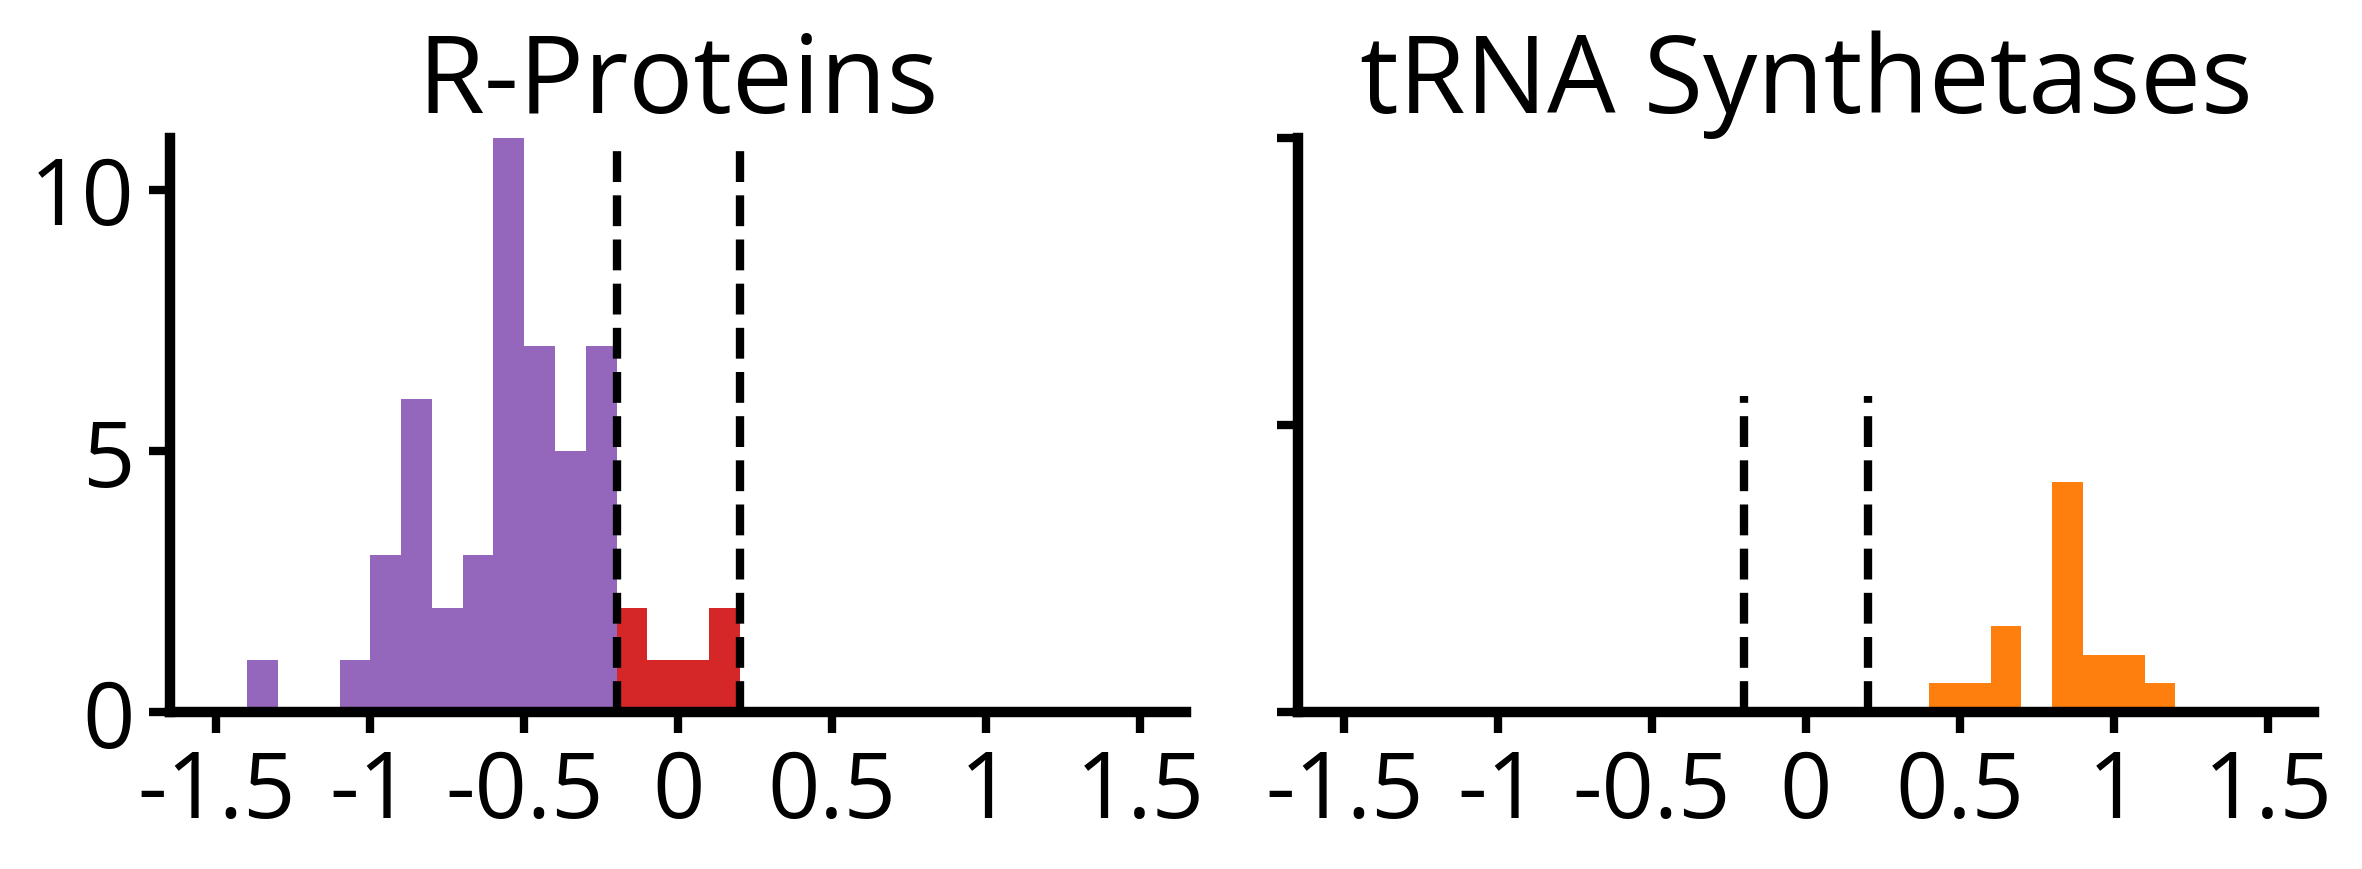

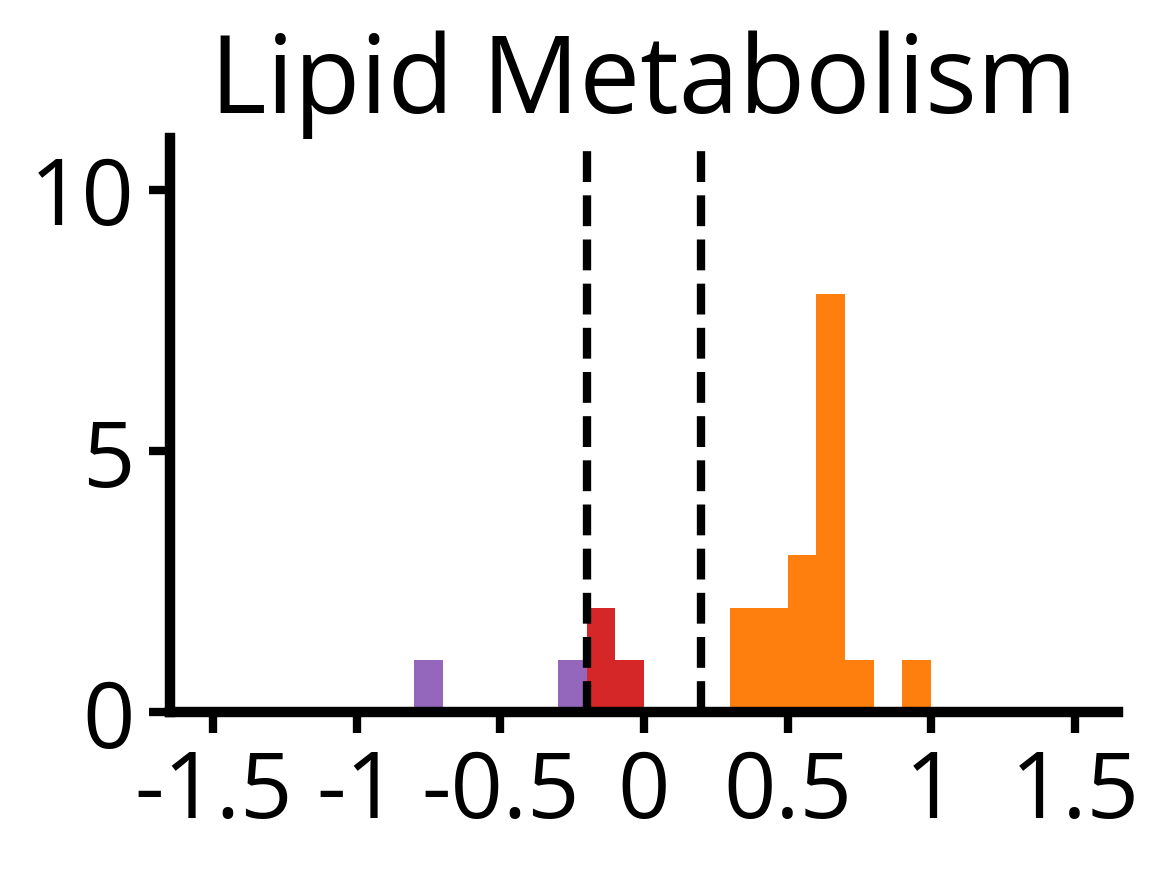

In [13]:
r_protein_slopes = all_slopes_filtered[all_slopes_filtered.index.isin(all_r_proteins)]
trna_slopes = all_slopes_filtered[all_slopes_filtered.index.isin(trna_synthetases)]
lipid_slopes = all_slopes_filtered[all_slopes_filtered.index.isin(lipid_metabolic_process)]

pos_slope_genes = r_protein_slopes[r_protein_slopes["Slope"]>=pos_slope_thr].index.tolist()
neg_slope_genes = r_protein_slopes[r_protein_slopes["Slope"]<=neg_slope_thr].index.tolist()
no_slope_genes = r_protein_slopes[(r_protein_slopes["Slope"]>neg_slope_thr)&\
                (r_protein_slopes["Slope"]<pos_slope_thr)].index.tolist()

fig,axes = plt.subplots(1,2,figsize=(8,3))

ax = axes[0]
ax.set_ylim(0,11)
ax.set_title("R-Proteins",fontsize=26)
ax.hist(r_protein_slopes[r_protein_slopes["Slope"]<=neg_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:purple")
ax.hist(r_protein_slopes[(r_protein_slopes["Slope"]>neg_slope_thr)&\
                             (r_protein_slopes["Slope"]<pos_slope_thr)]["Slope"],range=(-1.5,1.5),bins=30,color="tab:red")
ax.hist(r_protein_slopes[r_protein_slopes["Slope"]>=pos_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:orange")
ax.vlines([neg_slope_thr,pos_slope_thr],ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--",linewidth=2,color="black")

ax.set_xlabel(r"",fontsize=22)
ax.set_ylabel("",fontsize=22)
ax.set_xticks(ticks=[-1.5,-1,-0.5,0,0.5,1,1.5],labels=["-1.5","-1","-0.5","0","0.5","1","1.5"],minor=False)
ax.tick_params(axis='both', direction='out', labelsize=22,  width=2, length=5)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

ax = axes[1]
ax.set_ylim(0,11)
ax.set_title("tRNA Synthetases",fontsize=26)
ax.hist(trna_slopes[trna_slopes["Slope"]<=neg_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:purple")
ax.hist(trna_slopes[(trna_slopes["Slope"]>neg_slope_thr)&\
                             (trna_slopes["Slope"]<pos_slope_thr)]["Slope"],range=(-1.5,1.5),bins=30,color="tab:red")
ax.hist(trna_slopes[trna_slopes["Slope"]>=pos_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:orange")
ax.vlines([neg_slope_thr,pos_slope_thr],ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--",linewidth=2,color="black")

ax.set_xlabel(r"",fontsize=18)
ax.set_ylabel("",fontsize=22)
ax.set_yticks(ticks=[0,10,20],labels=["","",""],minor=False)
ax.set_xticks(ticks=[-1.5,-1,-0.5,0,0.5,1,1.5],labels=["-1.5","-1","-0.5","0","0.5","1","1.5"],minor=False)
ax.tick_params(axis='both', direction='out', labelsize=22,  width=2, length=5)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Slope_Hist_Decomp_Part1.png",transparent=True,dpi=500,bbox_inches="tight")

fig,ax = plt.subplots(1,1,figsize=(4,3))

ax.set_ylim(0,11)
ax.set_title("Lipid Metabolism",fontsize=26)
ax.hist(lipid_slopes[lipid_slopes["Slope"]<=neg_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:purple")
ax.hist(lipid_slopes[(lipid_slopes["Slope"]>neg_slope_thr)&\
                             (lipid_slopes["Slope"]<pos_slope_thr)]["Slope"],range=(-1.5,1.5),bins=30,color="tab:red")
ax.hist(lipid_slopes[lipid_slopes["Slope"]>=pos_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:orange")
ax.vlines([neg_slope_thr,pos_slope_thr],ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--",linewidth=2,color="black")

ax.set_xlabel(r"",fontsize=18)
ax.set_ylabel("",fontsize=22)
ax.set_xticks(ticks=[-1.5,-1,-0.5,0,0.5,1,1.5],labels=["-1.5","-1","-0.5","0","0.5","1","1.5"],minor=False)
ax.tick_params(axis='both', direction='out', labelsize=22,  width=2, length=5)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Slope_Hist_Decomp_Part2.png",transparent=True,dpi=500,bbox_inches="tight")

In [14]:
len(all_slopes_filtered)

185

In [15]:
len(all_slopes_filtered[all_slopes_filtered["Slope"]>0.2])

65

In [16]:
len(all_slopes_filtered[all_slopes_filtered["Slope"]<-0.2])

90

In [17]:
slow_r_protein_slopes = r_protein_slopes[r_protein_slopes["Min Growth"]<0.6]

In [18]:
len(slow_r_protein_slopes)

45

In [19]:
len(slow_r_protein_slopes[slow_r_protein_slopes["Slope"]>-0.2])

4

In [20]:
slow_r_protein_slopes[slow_r_protein_slopes["Slope"]>-0.2]

,Slope,Intercept,R2,Min Growth,Max Length,Min Length,Length at Min Growth Rate,Mean Abs Residual,CI
Gene,,,,,,,,,
rplI,-0.143220,2.082838,0.342711,0.392398,4.514791,3.449203,4.514791,0.053601,0.116902
rplJ,0.198369,1.568358,0.568675,0.190993,3.815069,2.829205,3.388677,0.080293,0.043577
rplL,0.169177,1.618266,0.507738,0.180076,3.801454,2.826300,3.290836,0.076023,0.044329
rpsA,0.023818,1.766329,0.007779,0.483422,4.093081,3.159693,4.093081,0.068414,0.132180


In [21]:
all_translation = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006412")
all_translation_slopes = all_slopes_filtered[all_slopes_filtered.index.isin(all_translation)]
slow_all_translation_slopes = all_translation_slopes[all_translation_slopes["Min Growth"]<0.6]

Searching for translation


In [22]:
len(slow_all_translation_slopes)

56

In [23]:
len(slow_all_translation_slopes[(slow_all_translation_slopes["Slope"]<0.2)&(slow_all_translation_slopes["Slope"]>-0.2)])

6

In [24]:
slow_all_translation_slopes[(slow_all_translation_slopes["Slope"]<0.2)&(slow_all_translation_slopes["Slope"]>-0.2)]

,Slope,Intercept,R2,Min Growth,Max Length,Min Length,Length at Min Growth Rate,Mean Abs Residual,CI
Gene,,,,,,,,,
infA,0.053898,1.873580,0.118461,0.317287,4.170288,3.430724,3.792321,0.055296,0.051474
infB,-0.088454,1.923066,0.140074,0.461900,4.032911,3.231320,4.032911,0.075523,0.107890
rplI,-0.143220,2.082838,0.342711,0.392398,4.514791,3.449203,4.514791,0.053601,0.116902
rplJ,0.198369,1.568358,0.568675,0.190993,3.815069,2.829205,3.388677,0.080293,0.043577
rplL,0.169177,1.618266,0.507738,0.180076,3.801454,2.826300,3.290836,0.076023,0.044329
rpsA,0.023818,1.766329,0.007779,0.483422,4.093081,3.159693,4.093081,0.068414,0.132180


## Figure 3D

In [25]:
ribo_stalk = ["rplJ","rplL"]
ribo = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0005840")
elongation_factors = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0003746")
trna_synthetases = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0043039")
initation_factors = ["infA","infB",]

all_ribo = ribo + elongation_factors + trna_synthetases + initation_factors

ribo_relabel = {**{item: "Ribosome" for item in list(set(ribo)-set(ribo_stalk))},**{item: "Elongation Factor" for item in elongation_factors},\
 **{item: "tRNA Synthetase" for item in trna_synthetases},**{item: "Ribosome Stalk" for item in ribo_stalk},\
               **{item: "Initiation Factor" for item in initation_factors}}

ribo_df = ss_estimators_df[ss_estimators_df["Gene"].isin(ribo)].copy()
ribo_df["Gene"] = ribo_df["Gene"].astype(str)
ribo_df["Ribo Type"] = ribo_df["Gene"].apply(lambda x: ribo_relabel[x])

all_ribo_df = ss_estimators_df[ss_estimators_df["Gene"].isin(all_ribo)].copy()
all_ribo_df["Gene"] = all_ribo_df["Gene"].astype(str)
all_ribo_df["Ribo Type"] = all_ribo_df["Gene"].apply(lambda x: ribo_relabel[x])

ribo_growth_df = all_ribo_df[["Length","Instantaneous Growth Rate: Volume"]]
tRNA_ribo_df = all_ribo_df[all_ribo_df["Ribo Type"].isin(['Ribosome', 'tRNA Synthetase', 'Ribosome Stalk', 'Initiation Factor'])]

Searching for ribosome
Searching for translation elongation factor activity
Searching for tRNA aminoacylation


In [26]:
WT_sgrna = 29672
rpsO_sgrna = 18952
rplQ_sgrna = 6217
rplA_sgrna = 4737

isolate_sgrnas = [rpsO_sgrna,rplQ_sgrna,rplA_sgrna]
isolate_ss_estimators_df = pd.concat([ss_estimators_df_controls_only.loc[[WT_sgrna]],ss_estimators_df.loc[isolate_sgrnas]])
isolate_ss_estimators_df["Isolate"] = ["WT","rpsO","rplQ","rplA"]

strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'rpsO':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902), \
                   'rplQ':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'rplA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

isolate_ss_estimators_df["Color"] = isolate_ss_estimators_df["Isolate"].apply(lambda x: strain_pallette[x])

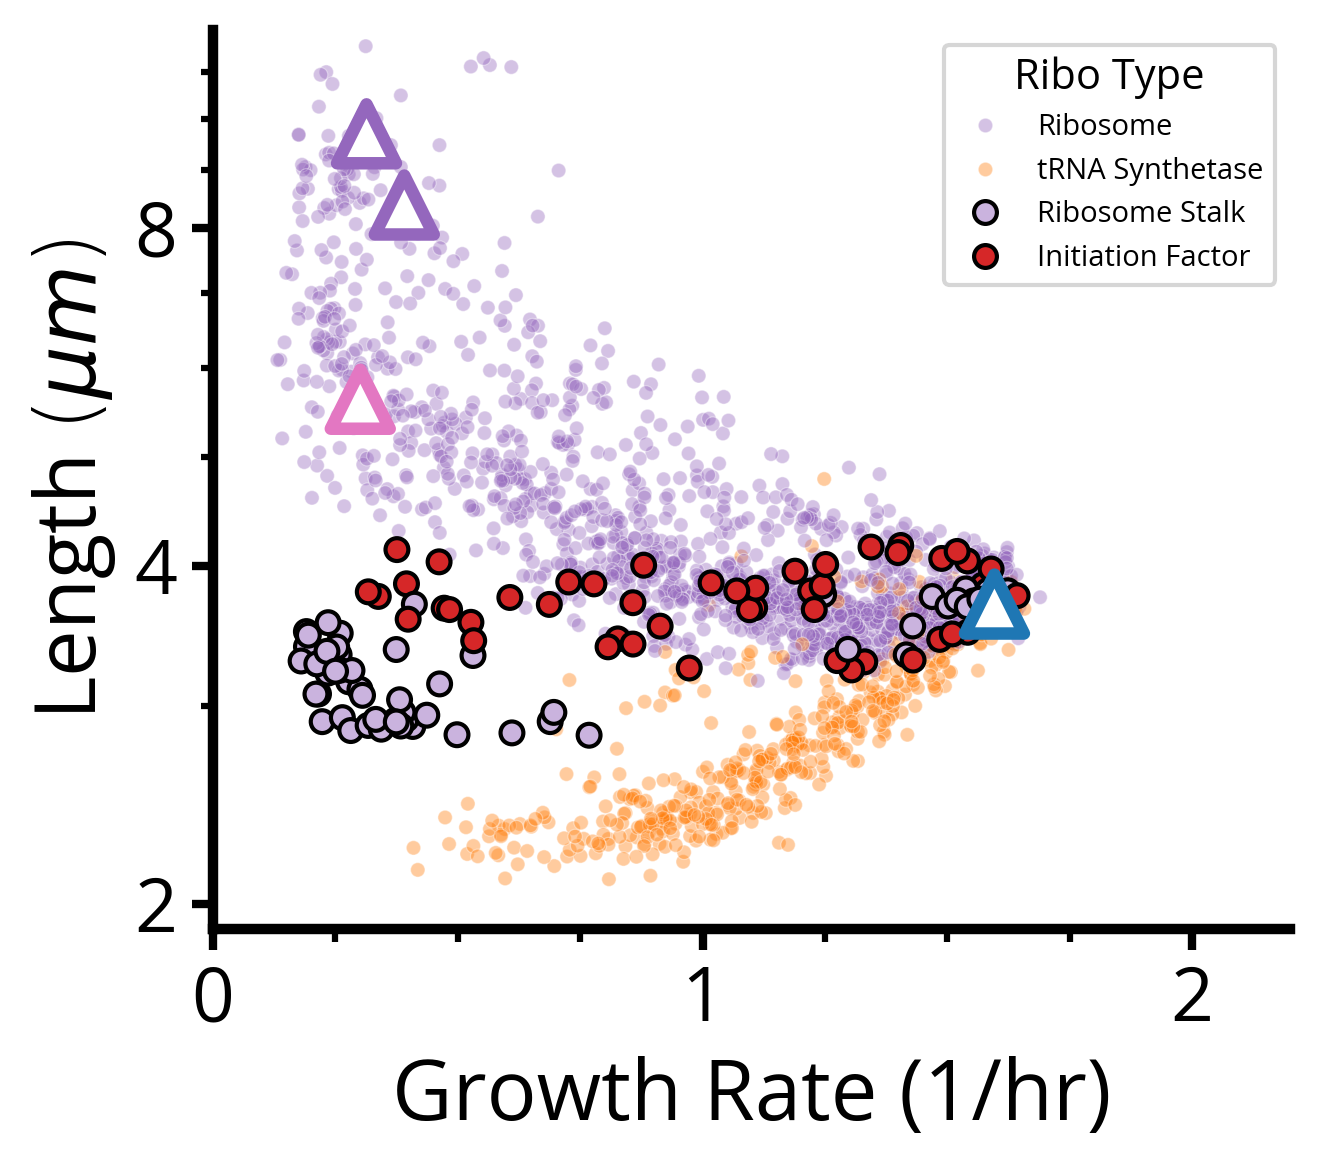

In [27]:
sns.set_style()
fig,ax = plt.subplots(1,1,figsize=(4.5,4))
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,12)
plt.yscale("log",base=2)

ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)

tRNA_ribo_df_main = tRNA_ribo_df[tRNA_ribo_df["Ribo Type"].isin(['Ribosome', 'tRNA Synthetase'])]
tRNA_ribo_df_sub = tRNA_ribo_df[~tRNA_ribo_df["Ribo Type"].isin(['Ribosome', 'tRNA Synthetase'])]


sns.scatterplot(x=tRNA_ribo_df_main["Instantaneous Growth Rate: Volume"],\
            y=tRNA_ribo_df_main["Length"],s=12,\
            hue=tRNA_ribo_df_main["Ribo Type"],\
            hue_order=['Ribosome', 'tRNA Synthetase'],\
            palette=[(0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                     (1.0, 0.4980392156862745, 0.054901960784313725)], ax=ax, zorder=-10, alpha=0.4)

# sns.scatterplot(x=tRNA_ribo_df_sub["Instantaneous Growth Rate: Volume"],\
#             y=tRNA_ribo_df_sub["Length"],s=30,\
#             hue=tRNA_ribo_df_sub["Ribo Type"],\
#             hue_order=['Ribosome Stalk', 'Initiation Factor'],\
#             palette=[(0.7901960784313726, 0.7019607843137254, 0.8705882352941177),\
#                      (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)], ax=ax, zorder=-9,\
#            edgecolor="black",linewidth=1)

sns.scatterplot(x=tRNA_ribo_df_sub["Instantaneous Growth Rate: Volume"],\
            y=tRNA_ribo_df_sub["Length"],s=30,\
            hue=tRNA_ribo_df_sub["Ribo Type"],\
            hue_order=['Ribosome Stalk', 'Initiation Factor'],\
            palette=[(0.7901960784313726, 0.7019607843137254, 0.8705882352941177),\
                     (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)], ax=ax, zorder=-9,\
           edgecolor="black",linewidth=1)

ax.scatter(isolate_ss_estimators_df["Instantaneous Growth Rate: Volume"],\
           isolate_ss_estimators_df["Length"], s=200,\
           c='white', edgecolors=isolate_ss_estimators_df["Color"],\
           linewidth=3,marker="^", zorder=-8)

plt.ylabel(r"Length $ (\mu m) $",fontsize=20)
plt.xlabel(r"Growth Rate (1/hr)",fontsize=20)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

# legend = ax.legend(fontsize=12,prop={'family': 'Open Sans', 'size': 12, 'weight': 'bold'})

# legend.legend_handles[0].set_markersize(8)
# legend.legend_handles[1].set_markersize(8)
# legend.legend_handles[2].set_markersize(8)
# legend.legend_handles[3].set_markersize(8)
# legend.get_texts()[0].set_text('Ribosome')
# legend.get_texts()[1].set_text('tRNA Synthetases')
# # legend.get_texts()[2].set_text('tRNA Synthetases')
# legend.get_texts()[3].set_text('Initiation Factors')

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/8hr_Induced_Length_Growth_Ribosome.png",dpi=500,transparent=True)

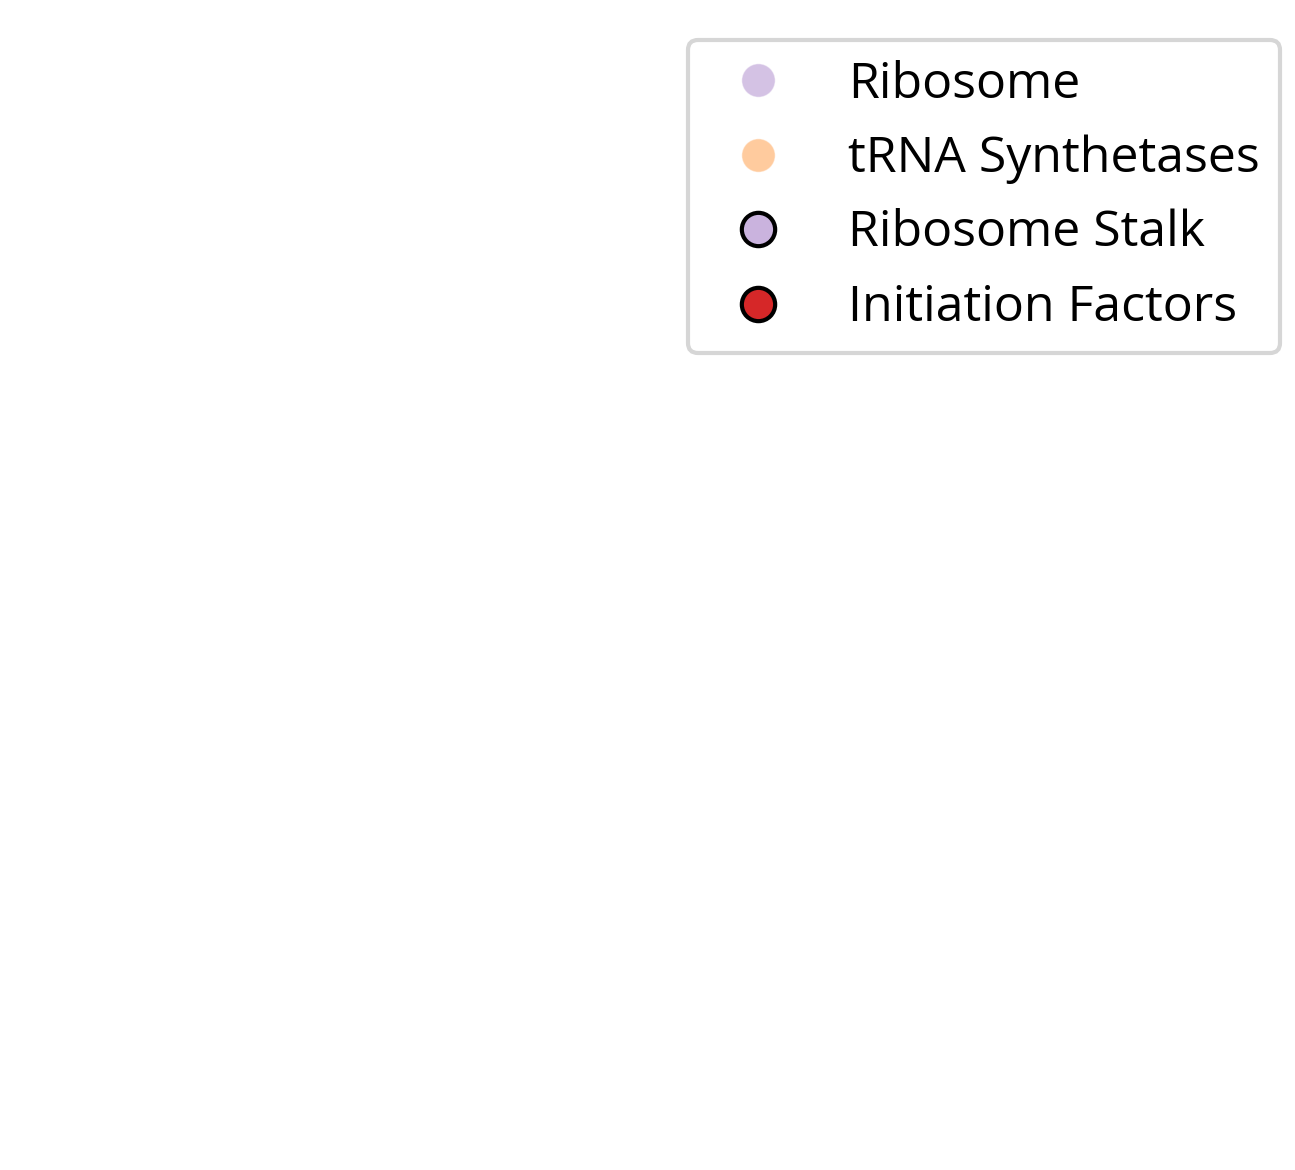

In [87]:
legend = ax.legend(fontsize=12)

legend.legend_handles[0].set_markersize(8)
legend.legend_handles[1].set_markersize(8)
legend.legend_handles[2].set_markersize(8)
legend.legend_handles[3].set_markersize(8)
legend.get_texts()[0].set_text('Ribosome')
legend.get_texts()[1].set_text('tRNA Synthetases')
# legend.get_texts()[2].set_text('tRNA Synthetases')
legend.get_texts()[3].set_text('Initiation Factors')
# Create a new figure for the legend
legend_fig = plt.figure(figsize=(4, 4))  # Adjust size as needed
legend_ax = legend_fig.add_subplot(111)
legend_ax.axis('off')  # Turn off axes for the legend figure
legend_ax.legend_ = legend  # Set the legend manually

# Show only the legend
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/8hr_Induced_Length_Growth_Ribosome_Legend.png",dpi=500,transparent=True)

## Figure 3E

In [28]:
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

ss_isolate_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/Mother_Machine_Imaging/2024-11-01_Steady_State_df_Estimators_wStats.pkl")
ss_isolate_estimators_df = ss_isolate_estimators_df.loc["Mean (Robust)"]

In [29]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Instantaneous Growth Rate: Volume']

min_n_observations = 8
sem_ratio_thr_ss = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<sem_ratio_thr_ss]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

# ##removing controls
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

wt_length = np.median(ss_estimators_df_controls_only["Length"])
wt_gr = np.median(ss_estimators_df_controls_only["Instantaneous Growth Rate: Volume"])

##import isolates

final_columns = ["Condition","Category"]
control_categories = ["Control"]

final_isolate_column_df = ss_isolate_estimators_df.reset_index().groupby("Condition Index").first()[final_columns]
ss_isolate_estimators_df["SEM/Location"] = (np.sqrt(ss_isolate_estimators_df["Estimator Variance"])/ss_isolate_estimators_df["Value"]).copy()
ss_isolate_estimators_df = ss_isolate_estimators_df[ss_isolate_estimators_df["SEM/Location"]<sem_ratio_thr_ss]
ss_isolate_estimators_df = ss_isolate_estimators_df.reset_index().set_index(["Condition Index"])

##hack to get both observatoins and proliferating observations (was broken)
isolate_observation_df = ss_isolate_estimators_df[ss_isolate_estimators_df["Variable(s)"] == "Length"][["N Observations"]]

isolate_variance_estimators_df = ss_isolate_estimators_df[["Variable(s)","Estimator Variance"]]
ss_isolate_estimators_df = ss_isolate_estimators_df[["Variable(s)","Value"]]
ss_isolate_estimators_df = ss_isolate_estimators_df.pivot(columns=["Variable(s)"])
isolate_variance_estimators_df = isolate_variance_estimators_df.pivot(columns=["Variable(s)"])

ss_isolate_estimators_df.columns = ss_isolate_estimators_df.columns.droplevel(0)
isolate_variance_estimators_df.columns = isolate_variance_estimators_df.columns.droplevel(0)
isolate_variance_estimators_df.columns = [column + " SEM" for column in isolate_variance_estimators_df.columns]
isolate_variance_estimators_df = np.sqrt(isolate_variance_estimators_df)
ss_isolate_estimators_df = ss_isolate_estimators_df.join(isolate_observation_df,on=['Condition Index'])
ss_isolate_estimators_df = ss_isolate_estimators_df.join(isolate_variance_estimators_df,on=['Condition Index'])

ss_isolate_estimators_df = ss_isolate_estimators_df[ss_isolate_estimators_df["N Observations"]>=min_n_observations]
ss_isolate_estimators_df["Instantaneous Growth Rate: Volume"] = ss_isolate_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_isolate_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_isolate_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_isolate_estimators_df = ss_isolate_estimators_df.join(final_isolate_column_df)
ss_isolate_estimators_df = ss_isolate_estimators_df.dropna(subset=params_of_interest)

ss_isolate_estimators_df_controls_only = ss_isolate_estimators_df[ss_isolate_estimators_df["Category"].isin(control_categories)]

isolate_wt_length = np.median(ss_isolate_estimators_df_controls_only["Length"])
isolate_wt_gr = np.median(ss_isolate_estimators_df_controls_only["Instantaneous Growth Rate: Volume"])

In [30]:
infA_sgrnaid = 20899
pheT_sgrnaid = 23961
wt_sgrnaid = 29672

# Define a custom palette, style consistent with rest of figure
strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'EV':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'tufA':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'rplL':(0.7901960784313726, 0.7019607843137254, 0.8705882352941177), \
                   'infA':(0.8874509803921569, 0.40705882352941175, 0.40980392156862744), \
                   'pheT':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'fusA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   r'$p_{AHL}$-fusA': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   'fusA*':(0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

## infA
infA_df = ss_estimators_df[ss_estimators_df["Gene"]=="infA"]
## pheT
pheT_df = ss_estimators_df[ss_estimators_df["Gene"]=="pheT"]
## rplL
rplL_df = ss_estimators_df[ss_estimators_df["Gene"]=="rplL"]
## controls
wt_df = ss_estimators_df_controls_only.loc[[wt_sgrnaid]]

## isolates
non_fusA_isolate_df = ss_isolate_estimators_df.loc[[9,10,11,12]]
non_fusA_isolate_df["Color"] = non_fusA_isolate_df["Condition"].apply(lambda x: strain_pallette[x])

fusA_isolate_df = ss_isolate_estimators_df.loc[[1,2,3,4,5,6,7,8]]
fusA_isolate_df["Color"] = [(0.5803921568627451, 0.403921568627451, 0.7411764705882353) for i in range(8)]

uninduced_fusA_isolate_df = ss_isolate_estimators_df.loc[[0]]
uninduced_fusA_isolate_df["Color"] = [(0.5803921568627451, 0.403921568627451, 0.7411764705882353) for i in range(1)]

/tmp/ipykernel_27912/162439946.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(fusA_isolate_df["Instantaneous Growth Rate: Volume"],\


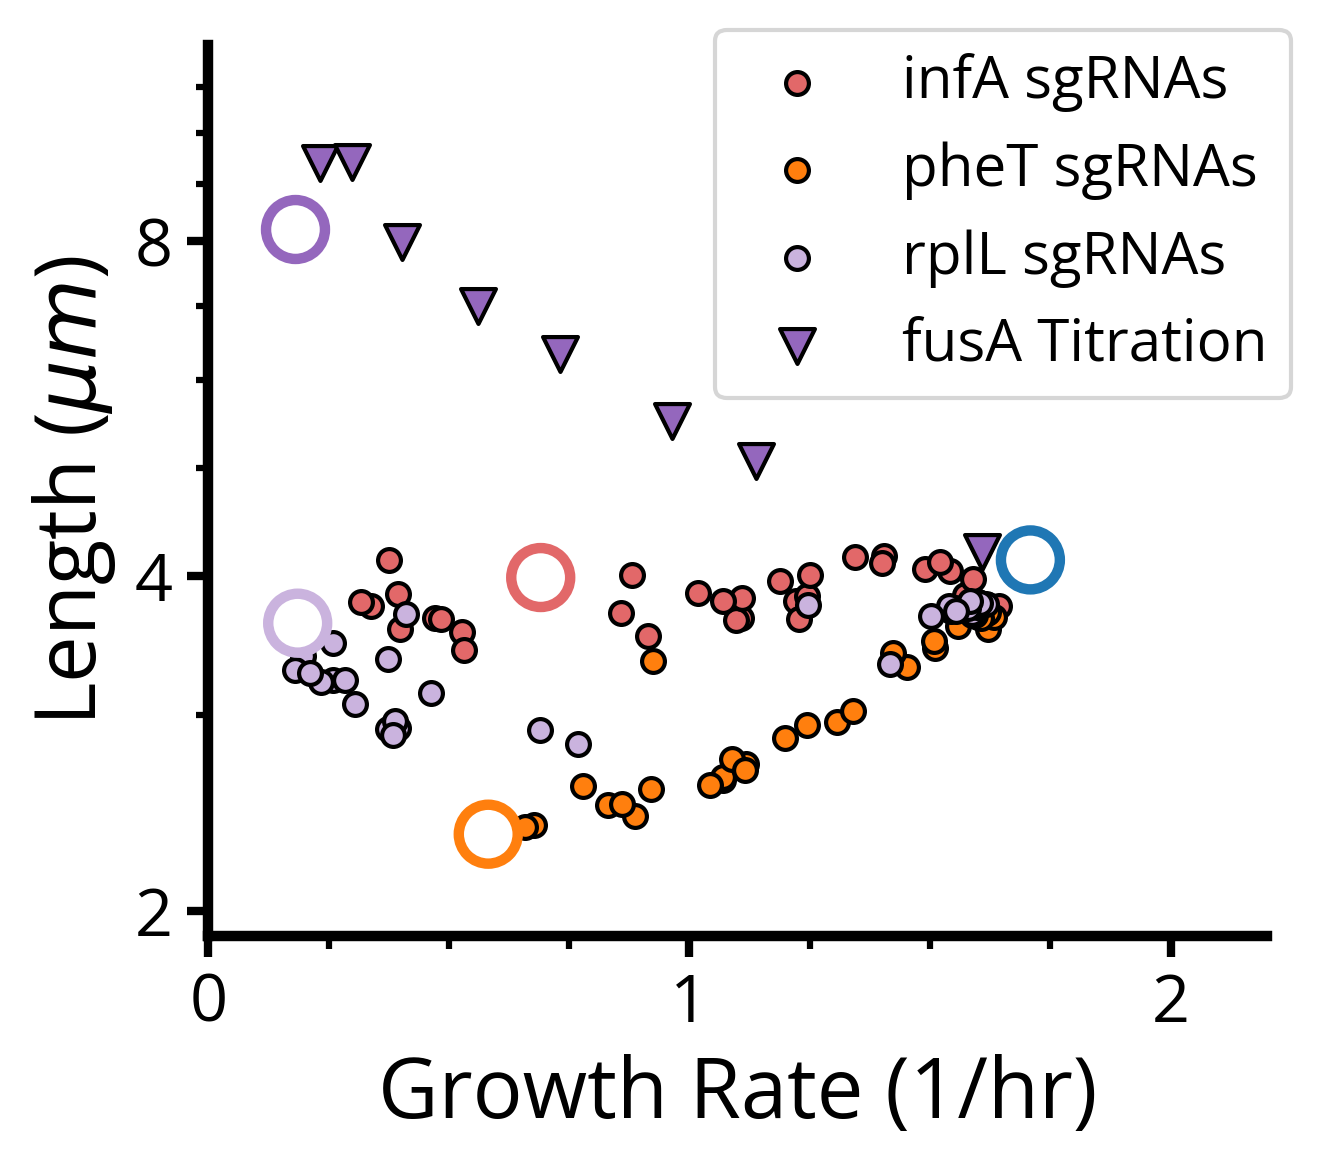

In [31]:
sns.set_style()
fig,ax = plt.subplots(1,1,figsize=(4.5,4))
ax.set_xlim(0,2.2)
ax.set_ylim(1.9,12)
plt.yscale("log",base=2)

ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1,2],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)

sns.scatterplot(x=infA_df["Instantaneous Growth Rate: Volume"],\
            y=infA_df["Length"],s=30,\
            color=strain_pallette["infA"], ax=ax, zorder=-10, alpha=1, edgecolor="black",linewidth=1,label="infA sgRNAs")
sns.scatterplot(x=pheT_df["Instantaneous Growth Rate: Volume"],\
            y=pheT_df["Length"],s=30,\
            color=strain_pallette["pheT"], ax=ax, zorder=-10, alpha=1, edgecolor="black",linewidth=1,label="pheT sgRNAs")
sns.scatterplot(x=rplL_df["Instantaneous Growth Rate: Volume"],\
            y=rplL_df["Length"],s=30,\
            color=strain_pallette["rplL"], ax=ax, zorder=-10, alpha=1, edgecolor="black",linewidth=1,label="rplL sgRNAs")

ax.scatter(non_fusA_isolate_df["Instantaneous Growth Rate: Volume"],\
           non_fusA_isolate_df["Length"], s=200,\
           c='white', edgecolors=non_fusA_isolate_df["Color"],\
           linewidth=2.5, zorder=-8)

ax.scatter(uninduced_fusA_isolate_df["Instantaneous Growth Rate: Volume"],\
           uninduced_fusA_isolate_df["Length"], s=200,\
           c='white', edgecolors=uninduced_fusA_isolate_df["Color"],\
           linewidth=2.5, zorder=-8)
ax.scatter(fusA_isolate_df["Instantaneous Growth Rate: Volume"],\
           fusA_isolate_df["Length"], s=70,\
           c=strain_pallette[r'$p_{AHL}$-fusA'],\
           zorder=-10, marker="v", alpha=1, edgecolor="black",linewidth=1,label="fusA Titration")

plt.ylabel(r"Length ($\mu m$)",fontsize=20)
plt.xlabel(r"Growth Rate (1/hr)",fontsize=20)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

legend = ax.legend(fontsize=14,bbox_to_anchor=(1.05, 1.05), loc='upper right')

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Growth_Length_InfA_PheT_FusA.png",dpi=500,transparent=True)

## Figure 3F

In [45]:
def get_sample_idx(sample_name_list):
    sample_idx = []
    for sample_name in sample_name_list:
        strain,replicate = sample_name.split("\n")
        replicate = int(replicate[1:])
        sample_idx.append((strain,replicate))
    return sample_idx

Protein_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_1.xlsx",skiprows=26,index_col=0,usecols=range(1,14))
Protein_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_2.xlsx",skiprows=26,index_col=0,usecols=range(1,14))
Protein_data_1 = pd.concat([Protein_data_plate_1,Protein_data_plate_2]).reset_index(drop=True)

RNA_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_1.xlsx",skiprows=30,index_col=0,usecols=range(1,14))
RNA_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_2.xlsx",skiprows=30,index_col=0,usecols=range(1,14))
RNA_data_1 = pd.concat([RNA_data_plate_1,RNA_data_plate_2]).reset_index(drop=True)

Protein_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_Map_1.xlsx",skipfooter=11,index_col=0,usecols=range(2))['Concentrations (ug/mL)'].to_dict()
RNA_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_Map_1.xlsx",skipfooter=9,index_col=0,usecols=range(2))['Concentrations (ng/ul)'].to_dict()

Protein_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_merged_1 = pd.concat([Protein_plate_map_1,Protein_plate_map_2]).reset_index(drop=True)
Protein_plate_map_merged_1.columns = Protein_plate_map_merged_1.columns.astype(int)

RNA_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_merged_1 = pd.concat([RNA_plate_map_1,RNA_plate_map_2]).reset_index(drop=True)
RNA_plate_map_merged_1.columns = RNA_plate_map_merged_1.columns.astype(int)

protein_samples_list_1,protein_sample_vals_list_1 = linear_regression(Protein_data_1,Protein_plate_map_merged_1,Protein_plate_map_standard_dict)
RNA_samples_list_1,RNA_sample_vals_list_1 = linear_regression(RNA_data_1,Protein_plate_map_merged_1,RNA_plate_map_standard_dict)

protein_samples_idx_1 = get_sample_idx(protein_samples_list_1)
Protein_output_df_1 = pd.DataFrame(protein_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","Replicate"]))

RNA_output_df_1 = (pd.DataFrame(RNA_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","Replicate"]))/2)*20
RNA_prot_ratio_df_1 = (RNA_output_df_1/Protein_output_df_1).sort_index()

RNA_prot_ratio_df_1 = RNA_prot_ratio_df_1.reset_index().set_index(["Strain","Replicate"])

RNA_prot_ratio_df = pd.concat([RNA_prot_ratio_df_1]).sort_index()
RNA_prot_ratio_df_translation = RNA_prot_ratio_df.reset_index()
RNA_prot_ratio_df_translation["Strain"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: int(x[2:]))
strain_name_map = {787:('WT','+'), 825:('WT','-'), 747:('tufA','+'), 824:('tufA','-'),
                   814:('rplL','+'), 818:('rplL','-'), 816:('infA','+'),820:('infA','-'),
                   817:('pheT','+'), 821:('pheT','-'), 815:('fusA','+'),819:('fusA','-'),
                   822:('fusA*','+'), 823:('fusA*','-'), 806:(r'$p_{AHL}$-fusA','+'),808:(r'$p_{AHL}$-fusA','-')}

RNA_prot_ratio_df_translation["Strain Name"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x][0])
RNA_prot_ratio_df_translation["relA"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x][1])
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.drop(columns=["Strain"], axis=0)
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.set_index(["Strain Name","relA","Replicate"])
RNA_prot_ratio_df_translation.columns = ['RNA/Protein']

LOQ: 0.1676043733933667
LOQ: 0.22608781129218272


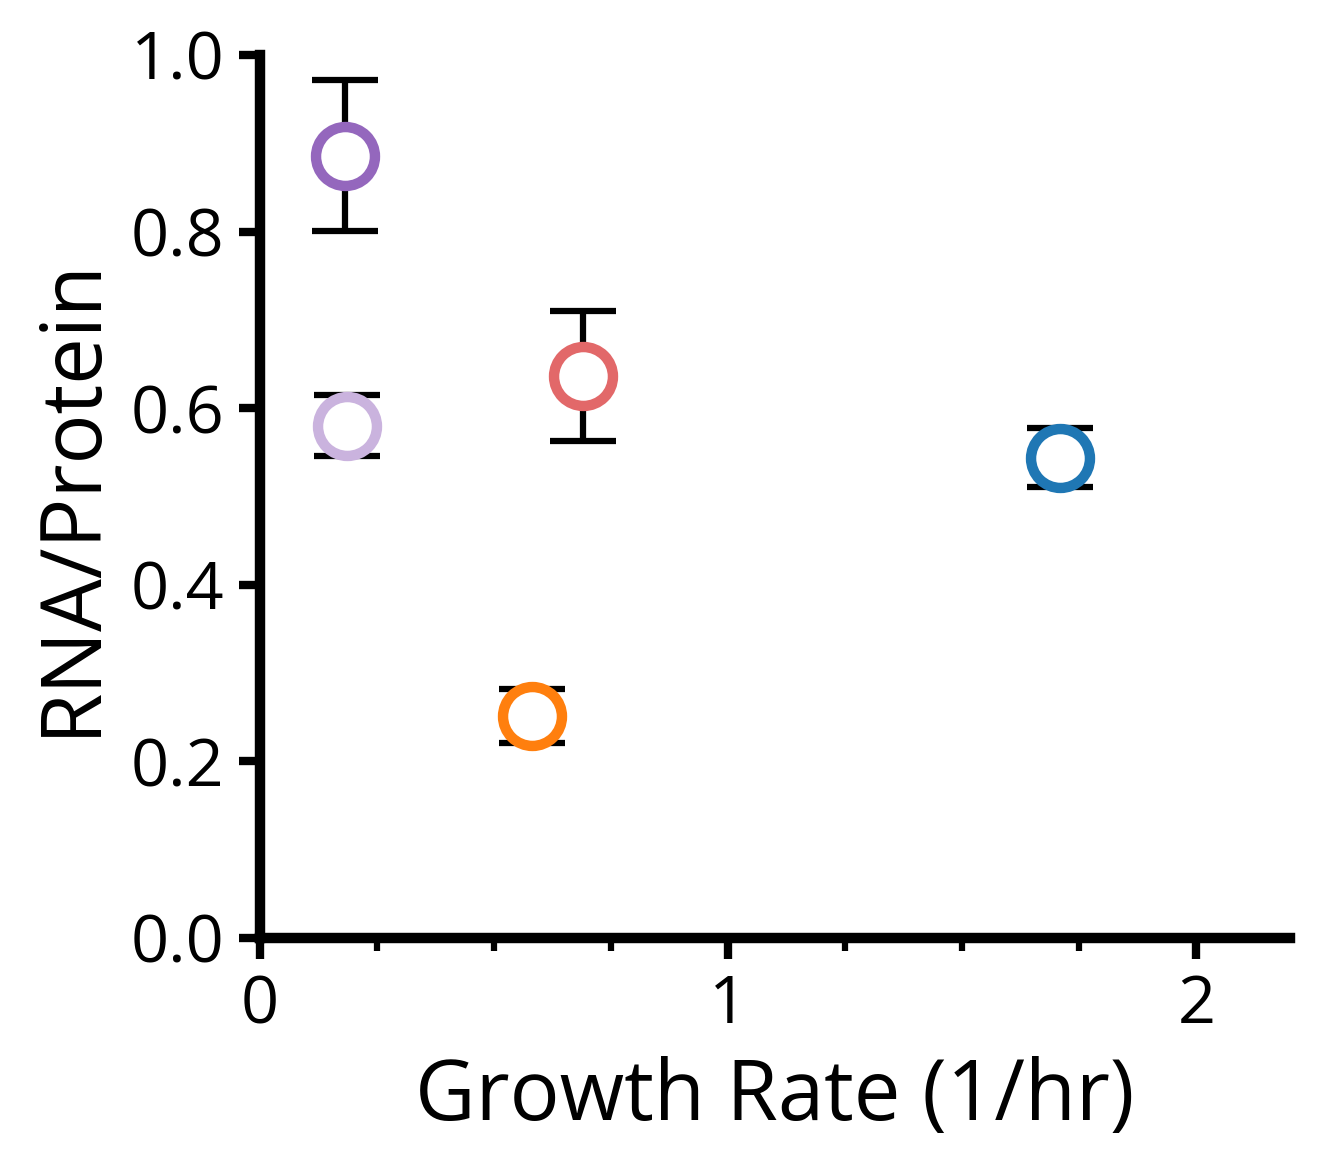

In [46]:
strain_order = ["WT","infA","pheT",r"$p_{AHL}$-fusA","rplL"]

RNA_prot_ratio_df_translation_subset = RNA_prot_ratio_df_translation.loc[strain_order]
RNA_Prot_data_mean = RNA_prot_ratio_df_translation_subset.groupby(["Strain Name","relA"])[["RNA/Protein"]].mean()
RNA_Prot_data_sem = RNA_prot_ratio_df_translation_subset.groupby(["Strain Name","relA"])[["RNA/Protein"]].sem()
RNA_Prot_data_agg = RNA_Prot_data_mean.join(RNA_Prot_data_sem.rename(columns={"RNA/Protein":"RNA/Protein SEM"}))

sns.set_style()
fig,ax = plt.subplots(1,1,figsize=(4.5,4))
ax.set_xlim(0,2.2)
plt.ylim(0,1)

ax.set_xticks(ticks=[0,1,2],labels=["0","1","2"],minor=False)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)

infA_growth_length_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="infA"]
pheT_growth_length_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="pheT"]
rplL_growth_length_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="rplL"]
EV_growth_length_df = non_fusA_isolate_df[non_fusA_isolate_df["Condition"]=="EV"]

ax.scatter(infA_growth_length_df["Instantaneous Growth Rate: Volume"],\
           RNA_Prot_data_mean.loc[("infA","+")]["RNA/Protein"], s=200,\
           c='white', edgecolors=infA_growth_length_df["Color"],\
           linewidth=2.5, zorder=-8)
plt.errorbar(infA_growth_length_df["Instantaneous Growth Rate: Volume"], RNA_Prot_data_mean.loc[("infA","+")]["RNA/Protein"],\
             xerr=None, yerr=2*RNA_Prot_data_sem.loc[("infA","+")]["RNA/Protein"],\
             ecolor='black', capsize=8, label="Data with error bars",capthick=1.5,elinewidth=1.5,zorder=-17)

ax.scatter(pheT_growth_length_df["Instantaneous Growth Rate: Volume"],\
           RNA_Prot_data_mean.loc[("pheT","+")]["RNA/Protein"], s=200,\
           c='white', edgecolors=pheT_growth_length_df["Color"],\
           linewidth=2.5, zorder=-8)
plt.errorbar(pheT_growth_length_df["Instantaneous Growth Rate: Volume"], RNA_Prot_data_mean.loc[("pheT","+")]["RNA/Protein"],\
             xerr=None, yerr=2*RNA_Prot_data_sem.loc[("pheT","+")]["RNA/Protein"],\
             ecolor='black', capsize=8, label="Data with error bars",capthick=1.5,elinewidth=1.5,zorder=-17)

ax.scatter(rplL_growth_length_df["Instantaneous Growth Rate: Volume"],\
           RNA_Prot_data_mean.loc[("rplL","+")]["RNA/Protein"], s=200,\
           c='white', edgecolors=rplL_growth_length_df["Color"],\
           linewidth=2.5, zorder=-8)
plt.errorbar(rplL_growth_length_df["Instantaneous Growth Rate: Volume"], RNA_Prot_data_mean.loc[("rplL","+")]["RNA/Protein"],\
             xerr=None, yerr=2*RNA_Prot_data_sem.loc[("rplL","+")]["RNA/Protein"],\
             ecolor='black', capsize=8, label="Data with error bars",capthick=1.5,elinewidth=1.5,zorder=-17)

ax.scatter(EV_growth_length_df["Instantaneous Growth Rate: Volume"],\
           RNA_Prot_data_mean.loc[("WT","+")]["RNA/Protein"], s=200,\
           c='white', edgecolors=EV_growth_length_df["Color"],\
           linewidth=2.5, zorder=-8)
plt.errorbar(EV_growth_length_df["Instantaneous Growth Rate: Volume"], RNA_Prot_data_mean.loc[("WT","+")]["RNA/Protein"],\
             xerr=None, yerr=2*RNA_Prot_data_sem.loc[("WT","+")]["RNA/Protein"],\
             ecolor='black', capsize=8, label="Data with error bars",capthick=1.5,elinewidth=1.5,zorder=-18)

ax.scatter(uninduced_fusA_isolate_df["Instantaneous Growth Rate: Volume"],\
           RNA_Prot_data_mean.loc[(r"$p_{AHL}$-fusA","+")]["RNA/Protein"], s=200,\
           c='white', edgecolors=uninduced_fusA_isolate_df["Color"],\
           linewidth=2.5, zorder=-8)
plt.errorbar(uninduced_fusA_isolate_df["Instantaneous Growth Rate: Volume"], RNA_Prot_data_mean.loc[(r"$p_{AHL}$-fusA","+")]["RNA/Protein"],\
             xerr=None, yerr=2*RNA_Prot_data_sem.loc[(r"$p_{AHL}$-fusA","+")]["RNA/Protein"],\
             ecolor='black', capsize=8, label="Data with error bars",capthick=1.5,elinewidth=1.5,zorder=-18)


plt.ylabel(r"RNA/Protein",fontsize=20)
plt.xlabel(r"Growth Rate (1/hr)",fontsize=20)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

# legend = ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_3/Ribosome_Growth_Bivariate.png",
                        dpi=500,transparent=True,bbox_inches="tight")